# 1 Setup

## 1.1 Setups

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
!pip install ethnicolr
!pip install pytorch-tabnet
!pip install torch

from ethnicolr import census_ln

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.5/39.5 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.2 Import data

In [16]:
# Get data
cand_data = pd.read_excel('/content/drive/MyDrive/Candidate Platforms and Endorsements/Data files/merged_final_candidate_data.xlsx')
cand_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31936 entries, 0 to 31935
Columns: 132 entries, Unnamed: 0 to gender
dtypes: float64(74), int64(37), object(21)
memory usage: 32.2+ MB


In [17]:
cand_data

,Unnamed: 0,cntyname,year,place,last,first,baldesig,office,incumb,co#,...,year_1999,year_2003,year_2005,year_2007,year_2011,year_2015,year_2021,year_2013,year_2017,gender
0,0,alameda,1996,alameda board of education,greely,gail ann,incumbent and parent,BOARD MEMBER,y,1,...,0,0,0,0,0,0,0,0,0,0.0
1,1,alameda,1996,alameda board of education,guenther,barbara m.,parent/case manager/advocate,BOARD MEMBER,n,1,...,0,0,0,0,0,0,0,0,0,0.0
2,2,alameda,1996,alameda board of education,huie,sam,grandparent/computer professional,BOARD MEMBER,n,1,...,0,0,0,0,0,0,0,0,0,1.0
3,3,alameda,1996,alameda board of education,linebarry,claude s. butch,management consultant,BOARD MEMBER,n,1,...,0,0,0,0,0,0,0,0,0,1.0
4,4,alameda,1996,alameda board of education,mcmahon,michael,systems analyst,BOARD MEMBER,n,1,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31931,37723,yuba,2016,wheatland union high,schweitz,debbie,incumbent,SCHOOL BOARD MEMBER,y,58,...,0,0,0,0,0,0,0,0,0,0.0
31932,37724,yuba,2020,wheatland union high,agles,patti,no ballot designation,SCHOOL BOARD MEMBER,n,58,...,0,0,0,0,0,0,0,0,0,0.0
31933,37725,yuba,2020,wheatland union high,forest,greg,no ballot designation,SCHOOL BOARD MEMBER,n,58,...,0,0,0,0,0,0,0,0,0,1.0
31934,37726,yuba,2020,wheatland union high,mchugh,brendan,no ballot designation,SCHOOL BOARD MEMBER,n,58,...,0,0,0,0,0,0,0,0,0,1.0


In [18]:
# Replace candidates district with standardized DOE match
cand_data['place'] = cand_data['matches']
del cand_data['matches']
cand_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31936 entries, 0 to 31935
Columns: 131 entries, Unnamed: 0 to gender
dtypes: float64(74), int64(37), object(20)
memory usage: 31.9+ MB


In [19]:
# Standardize elected/new elected to be 1 if elected, 0 if not
cand_data['elected'] = cand_data['elected'].replace(2, 0)
cand_data['newelected'] = cand_data['newelected'].replace(2, 0)
cand_data['newelected'] = cand_data['newelected'].replace(3, 0) # Runoff, not sure what to do???
# Standardize incumb to 1 if incumbent, 0 if not
cand_data['incumb'] = cand_data['incumb'].replace('n', 0)
cand_data['incumb'] = cand_data['incumb'].replace('y', 1)
cand_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31936 entries, 0 to 31935
Columns: 131 entries, Unnamed: 0 to gender
dtypes: float64(74), int64(38), object(19)
memory usage: 31.9+ MB


In [20]:
# Only get rows with candidate statements
#cand_data = cand_data.dropna()
#cand_data = cand_data[(cand_data['priorities'] != 'NA/NO BIO') & (cand_data['priorities'] != 'NA/MISSING INFO') & (cand_data['place'] != 'none')]
cand_data.info()
cand_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31936 entries, 0 to 31935
Columns: 131 entries, Unnamed: 0 to gender
dtypes: float64(74), int64(38), object(19)
memory usage: 31.9+ MB


,Unnamed: 0,cntyname,year,place,last,first,baldesig,office,incumb,co#,...,year_1999,year_2003,year_2005,year_2007,year_2011,year_2015,year_2021,year_2013,year_2017,gender
0,0,alameda,1996,alameda unified,greely,gail ann,incumbent and parent,BOARD MEMBER,1,1,...,0,0,0,0,0,0,0,0,0,0.0
1,1,alameda,1996,alameda unified,guenther,barbara m.,parent/case manager/advocate,BOARD MEMBER,0,1,...,0,0,0,0,0,0,0,0,0,0.0
2,2,alameda,1996,alameda unified,huie,sam,grandparent/computer professional,BOARD MEMBER,0,1,...,0,0,0,0,0,0,0,0,0,1.0
3,3,alameda,1996,alameda unified,linebarry,claude s. butch,management consultant,BOARD MEMBER,0,1,...,0,0,0,0,0,0,0,0,0,1.0
4,4,alameda,1996,alameda unified,mcmahon,michael,systems analyst,BOARD MEMBER,0,1,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31931,37723,yuba,2016,wheatland union high,schweitz,debbie,incumbent,SCHOOL BOARD MEMBER,1,58,...,0,0,0,0,0,0,0,0,0,0.0
31932,37724,yuba,2020,wheatland union high,agles,patti,no ballot designation,SCHOOL BOARD MEMBER,0,58,...,0,0,0,0,0,0,0,0,0,0.0
31933,37725,yuba,2020,wheatland union high,forest,greg,no ballot designation,SCHOOL BOARD MEMBER,0,58,...,0,0,0,0,0,0,0,0,0,1.0
31934,37726,yuba,2020,wheatland union high,mchugh,brendan,no ballot designation,SCHOOL BOARD MEMBER,0,58,...,0,0,0,0,0,0,0,0,0,1.0


In [21]:
# add ethnicity features https://ethnicolr.readthedocs.io/ethnicolr.html
from ethnicolr import pred_wiki_ln, pred_wiki_name

temp = cand_data[['first', 'last']].copy()
ethnicities = pred_wiki_name(temp, 'last', 'first')
cand_data = pd.merge(cand_data, ethnicities, on=['first', 'last'], how='left')
ethnicities.info()
cand_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24395 entries, 0 to 24394
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   first                                  24395 non-null  object 
 1   last                                   24395 non-null  object 
 2   Asian,GreaterEastAsian,EastAsian       24395 non-null  float32
 3   Asian,GreaterEastAsian,Japanese        24395 non-null  float32
 4   Asian,IndianSubContinent               24395 non-null  float32
 5   GreaterAfrican,Africans                24395 non-null  float32
 6   GreaterAfrican,Muslim                  24395 non-null  float32
 7   GreaterEuropean,British                24395 non-null  float32
 8   GreaterEuropean,EastEuropean           24395 non-null  float32
 9   GreaterEuropean,Jewish                 24395 non-null  float32
 10  GreaterEuropean,WestEuropean,French    24395 non-null  float32
 11  Gr

In [ ]:
list(cand_data.columns.values)

In [23]:
cleaned_data = cand_data[['leaid',
                          'year',
                          'incumb',
                          'longitude',
                          'latitude',
                          'enrollment',
                          'est_population_total',
                          'english_language_learners',
                          'est_population_5_17_pct',
                          'est_population_5_17_poverty_pct',
                          'number_of_schools',
                          'topic_0',
                          'topic_1',
                          'topic_2',
                          'topic_3',
                          'topic_4',
                          'topic_5',
                          'topic_6',
                          'topic_7',
                          'topic_8',
                          'topic_9',
                          'leaid_year_count',
                          'year_1996',
                          'year_2000',
                          'year_2004',
                          'year_2006',
                          'year_2010',
                          'year_1998',
                          'year_2008',
                          'year_2012',
                          'year_2016',
                          'year_2020',
                          'year_2014',
                          'year_2018',
                          'year_2022',
                          'year_2002',
                          'year_2019',
                          'year_1997',
                          'year_2001',
                          'year_2009',
                          'year_1999',
                          'year_2003',
                          'year_2005',
                          'year_2007',
                          'year_2011',
                          'year_2015',
                          'year_2021',
                          'year_2013',
                          'year_2017',
                           'Asian,GreaterEastAsian,EastAsian',
                           'Asian,GreaterEastAsian,Japanese',
                           'Asian,IndianSubContinent',
                           'GreaterAfrican,Africans',
                           'GreaterAfrican,Muslim',
                           'GreaterEuropean,British',
                           'GreaterEuropean,EastEuropean',
                           'GreaterEuropean,Jewish',
                           'GreaterEuropean,WestEuropean,French',
                           'GreaterEuropean,WestEuropean,Germanic',
                           'GreaterEuropean,WestEuropean,Hispanic',
                           'GreaterEuropean,WestEuropean,Italian',
                           'GreaterEuropean,WestEuropean,Nordic',
                          # 'race',
                          'gender',
                          'newelected'
                           ]]
cleaned_data = cleaned_data[(cleaned_data['leaid'] != -1) & cleaned_data['leaid'].notna()]
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31936 entries, 0 to 31935
Data columns (total 64 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   leaid                                  31936 non-null  int64  
 1   year                                   31936 non-null  int64  
 2   incumb                                 31936 non-null  int64  
 3   longitude                              16012 non-null  float64
 4   latitude                               16012 non-null  float64
 5   enrollment                             29407 non-null  float64
 6   est_population_total                   26060 non-null  float64
 7   english_language_learners              24580 non-null  float64
 8   est_population_5_17_pct                26060 non-null  float64
 9   est_population_5_17_poverty_pct        26060 non-null  float64
 10  number_of_schools                      29419 non-null  float64
 11  to

In [24]:
grouped = cleaned_data.groupby('leaid')
print(cleaned_data[['longitude', 'latitude']].isnull().sum())

print(len(grouped))
ids = {}

# Iterate through each group
for leaid, group in grouped:
    # print(f"Processing group with leaid: {leaid}")

    # Check if there are any rows with non-null 'longitude' and 'latitude'
    valid_rows = cleaned_data[['longitude', 'latitude']].notnull().all(axis=1)

    if valid_rows.any():
        #print(f"Found rows ({len(valid_rows)} of them) with valid 'longitude' and 'latitude' in this group. ")
        # Check if there are missing values before filling
        #missing_before = group[['longitude', 'latitude']].isnull().sum()
        #print(f"Missing values before filling:\n{missing_before}")

        mean_longitude = cleaned_data.loc[valid_rows, 'longitude'].mean()
        mean_latitude = cleaned_data.loc[valid_rows, 'latitude'].mean()

        # Forward fill missing values in 'longitude' and 'latitude' with mean values
        cleaned_data['longitude'].fillna(value=mean_longitude, inplace=True)
        cleaned_data['latitude'].fillna(value=mean_latitude, inplace=True)

        # Check if there are missing values after filling
        #missing_after = cleaned_data.loc[group.index, ['longitude', 'latitude']].isnull().sum()

    else:
        print(f"No rows with valid 'longitude' and 'latitude' in this group.")

# Check if there are still any missing values
missing_values = cleaned_data[['longitude', 'latitude']].isnull().sum()
print(f"Remaining missing values: {missing_values}")
# print(len(ids.keys()))


longitude    15924
latitude     15924
dtype: int64
834
Remaining missing values: longitude    0
latitude     0
dtype: int64


In [25]:
cleaned_data.sort_values(by=['leaid', 'year'], inplace=True)

# Forward fill missidng values in 'percent' column within each group ('leaid')
cleaned_data['est_population_total'] = cleaned_data.groupby('leaid')['est_population_total'].fillna(method='ffill')
cleaned_data['est_population_5_17_poverty_pct'] = cleaned_data.groupby('leaid')['est_population_5_17_poverty_pct'].fillna(method='ffill')
cleaned_data['english_language_learners'] = cleaned_data.groupby('leaid')['english_language_learners'].fillna(method='ffill')
cleaned_data['est_population_5_17_pct'] = cleaned_data.groupby('leaid')['est_population_5_17_pct'].fillna(method='ffill')
cleaned_data['number_of_schools'] = cleaned_data.groupby('leaid')['number_of_schools'].fillna(method='ffill')
cleaned_data['enrollment'] = cleaned_data.groupby('leaid')['enrollment'].fillna(method='ffill')


In [ ]:
cleaned_data.info()

In [27]:
cleaned_data = cleaned_data.dropna()

In [28]:
cleaned_data

,leaid,year,incumb,longitude,latitude,enrollment,est_population_total,english_language_learners,est_population_5_17_pct,est_population_5_17_poverty_pct,...,"GreaterEuropean,British","GreaterEuropean,EastEuropean","GreaterEuropean,Jewish","GreaterEuropean,WestEuropean,French","GreaterEuropean,WestEuropean,Germanic","GreaterEuropean,WestEuropean,Hispanic","GreaterEuropean,WestEuropean,Italian","GreaterEuropean,WestEuropean,Nordic",gender,newelected
7677,600001,2005,0,-119.715134,36.098043,1909.0,12287.0,175.0,0.218605,0.065897,...,0.824323,0.003704,0.114354,0.007832,0.001939,0.009460,0.009086,0.010007,1.0,1
7678,600001,2005,0,-119.715134,36.098043,1909.0,12287.0,175.0,0.218605,0.065897,...,0.968886,0.003436,0.013655,0.005311,0.000928,0.000775,0.000371,0.000103,1.0,0
7679,600001,2005,0,-119.715134,36.098043,1909.0,12287.0,175.0,0.218605,0.065897,...,0.408484,0.001338,0.029386,0.235289,0.006613,0.104631,0.094696,0.001923,0.0,0
7680,600001,2005,0,-119.715134,36.098043,1909.0,12287.0,175.0,0.218605,0.065897,...,0.495067,0.003736,0.116312,0.111517,0.153739,0.020498,0.017342,0.009832,1.0,1
7681,600001,2005,1,-119.715134,36.098043,1909.0,12287.0,175.0,0.218605,0.065897,...,0.006494,0.098208,0.084480,0.093583,0.012407,0.192174,0.104853,0.001907,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17657,691135,2008,0,-117.214104,33.837399,19183.0,57880.0,4786.0,0.237768,0.172504,...,0.532329,0.000180,0.029019,0.355818,0.000943,0.038718,0.013168,0.000069,1.0,1
17671,691135,2012,1,-117.204880,33.837357,19832.0,84243.0,4935.0,0.245552,0.260611,...,0.429738,0.001908,0.065799,0.346301,0.004914,0.112191,0.011393,0.005001,1.0,0
17683,691135,2018,0,-117.246808,33.836972,20141.0,90999.0,3966.0,0.226937,0.185754,...,0.882593,0.003283,0.034021,0.021809,0.007397,0.009466,0.008781,0.011653,1.0,1
17689,691135,2022,1,-119.715134,36.098043,19303.0,92434.0,3966.0,0.224365,0.148802,...,0.882593,0.003283,0.034021,0.021809,0.007397,0.009466,0.008781,0.011653,1.0,0


In [73]:
unique_years = sorted([int(col.split('_')[1]) for col in cleaned_data.columns if col.startswith('year_')])

print(unique_years)
# Set the window size for training and validation
window_size = 5  # Adjust this based on your requirement

# Create a list of tuples containing training and validation dataframes
datasets = []
for i in range(len(unique_years) - window_size - 4):

    train_years = unique_years[i:i+window_size]
    print('train years: ', train_years)
    val_years = unique_years[i+window_size:i+2*window_size]
    print('val years: ', val_years)
    train_mask = cleaned_data[cleaned_data.columns[cleaned_data.columns.isin([f'year_{year}' for year in train_years])]].any(axis=1)
    val_mask = cleaned_data[cleaned_data.columns[cleaned_data.columns.isin([f'year_{year}' for year in val_years])]].any(axis=1)

    train_data = cleaned_data[train_mask]
    val_data = cleaned_data[val_mask]

    datasets.append((train_data, val_data))


print(len(datasets))

validation_accuracies = []
# Access each element of the list and train/validate your models
for train_df, val_df in datasets:
    # Your training and validation code here
    print(train_df.shape)
    print(val_df.shape)
    features = train_df[[ 'incumb',
                          'longitude',
                          'latitude',
                          'enrollment',
                          'est_population_total',
                          'english_language_learners',
                          'est_population_5_17_pct',
                          'est_population_5_17_poverty_pct',
                          'number_of_schools',
                          'topic_0',
                          'topic_1',
                          'topic_2',
                          'topic_3',
                          'topic_4',
                          'topic_5',
                          'topic_6',
                          'topic_7',
                          'topic_8',
                          'topic_9',
                          'leaid_year_count',
                          'Asian,GreaterEastAsian,EastAsian',
                          'Asian,GreaterEastAsian,Japanese',
                          'Asian,IndianSubContinent',
                          'GreaterAfrican,Africans',
                          'GreaterAfrican,Muslim',
                          'GreaterEuropean,British',
                          'GreaterEuropean,EastEuropean',
                          'GreaterEuropean,Jewish',
                          'GreaterEuropean,WestEuropean,French',
                          'GreaterEuropean,WestEuropean,Germanic',
                          'GreaterEuropean,WestEuropean,Hispanic',
                          'GreaterEuropean,WestEuropean,Italian',
                          'GreaterEuropean,WestEuropean,Nordic',
                          'gender',
                          #'race'
                          ]]
    labels = train_df.iloc[:, -1]  # Extracting the last column as labels

    # extract the split
    X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.00001, random_state=42)

    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

    # Define logistic regression model
    class LogisticRegression(nn.Module):
        def __init__(self, input_size):
            super(LogisticRegression, self).__init__()
            self.linear = nn.Linear(input_size, 1)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            out = self.linear(x)
            out = self.sigmoid(out)
            return out

    # Initialize the model, loss function, and optimizer
    input_size = X_train_tensor.shape[1]
    model = LogisticRegression(input_size)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay = 1e-4)

    # Training loop
    num_epochs = 1500
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Forward pass
        outputs_tensor = model(X_train_tensor)
        loss_tensor = criterion(outputs_tensor, y_train_tensor.view(-1, 1))

        # Calculate accuracy
        predictions_tensor = (outputs_tensor >= 0.5).float()
        accuracy_tensor = torch.mean((predictions_tensor == y_train_tensor.view(-1, 1)).float())

        # Backward and optimize
        optimizer.zero_grad()
        loss_tensor.backward()
        optimizer.step()

        # Validation loss and accuracy
        with torch.no_grad():
            val_outputs_tensor = model(X_val_tensor)
            val_loss_tensor = criterion(val_outputs_tensor, y_val_tensor.view(-1, 1))
            val_predictions_tensor = (val_outputs_tensor >= 0.5).float()
            val_accuracy_tensor = torch.mean((val_predictions_tensor == y_val_tensor.view(-1, 1)).float())

        # Save losses and accuracies for plotting
        train_losses.append(loss_tensor.item())
        val_losses.append(val_loss_tensor.item())
        train_accuracies.append(accuracy_tensor.item())
        val_accuracies.append(val_accuracy_tensor.item())

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss_tensor.item():.4f}, Training Accuracy: {accuracy_tensor.item():.4f}, Validation Loss: {val_loss_tensor.item():.4f}, Validation Accuracy: {val_accuracy_tensor.item():.4f}')

    validation_accuracies.append(val_accuracy_tensor.item())


print(validation_accuracies)





[1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
train years:  [1996, 1997, 1998, 1999, 2000]
val years:  [2001, 2002, 2003, 2004, 2005]
train years:  [1997, 1998, 1999, 2000, 2001]
val years:  [2002, 2003, 2004, 2005, 2006]
train years:  [1998, 1999, 2000, 2001, 2002]
val years:  [2003, 2004, 2005, 2006, 2007]
train years:  [1999, 2000, 2001, 2002, 2003]
val years:  [2004, 2005, 2006, 2007, 2008]
train years:  [2000, 2001, 2002, 2003, 2004]
val years:  [2005, 2006, 2007, 2008, 2009]
train years:  [2001, 2002, 2003, 2004, 2005]
val years:  [2006, 2007, 2008, 2009, 2010]
train years:  [2002, 2003, 2004, 2005, 2006]
val years:  [2007, 2008, 2009, 2010, 2011]
train years:  [2003, 2004, 2005, 2006, 2007]
val years:  [2008, 2009, 2010, 2011, 2012]
train years:  [2004, 2005, 2006, 2007, 2008]
val years:  [2009, 2010, 2011, 2012, 2013]
train years:  [2005, 2006, 2007, 2008, 2009]


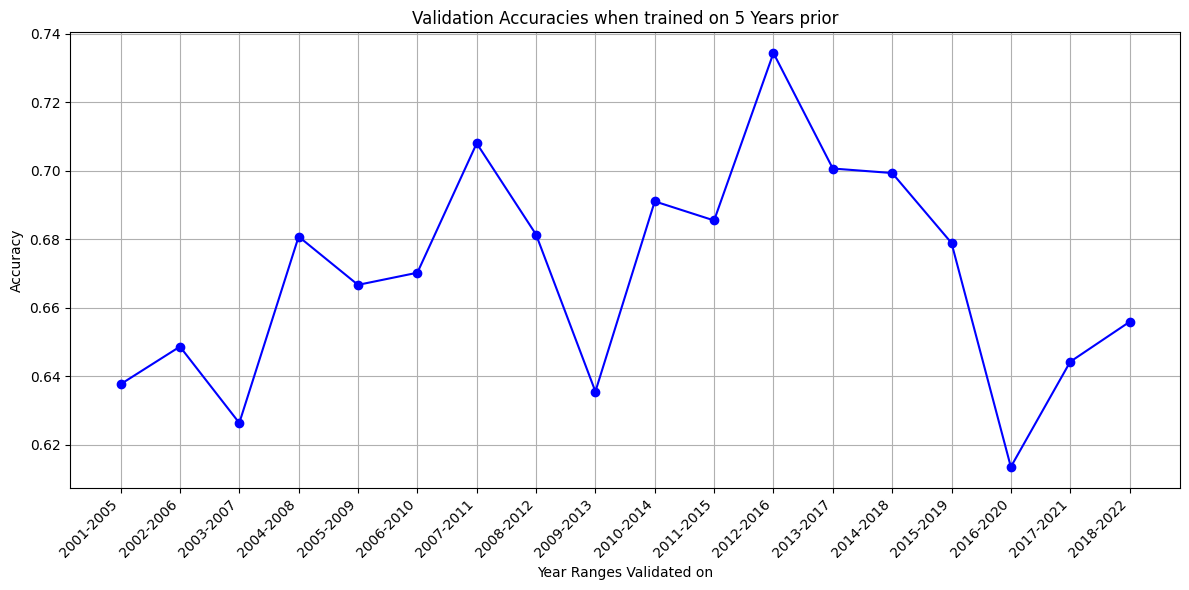

In [89]:
unique_years = [2004, 2006, 2010, 2008, 2012, 2016,
                2014, 2002, 2001, 2009, 2003,
                2005, 2007, 2011, 2015, 2013, 2017, 2018]

# Sort the list in ascending order
unique_years_sorted = sorted(unique_years)

# Plotting the accuracies
plt.figure(figsize=(12, 6))
iteration_numbers = range(1, len(validation_accuracies) + 1)
plt.plot(iteration_numbers, validation_accuracies, marker='o', linestyle='-', color='b')
plt.title('Validation Accuracies when trained on 5 Years prior')
plt.xlabel('Year Ranges Validated on')
plt.ylabel('Accuracy')
# Use unique_years_sorted directly for xticks
plt.xticks(iteration_numbers, [f'{year}-{year+window_size-1}' for year in unique_years_sorted], rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim import lr_scheduler


features = cleaned_data[[ 'incumb',
                          'longitude',
                          'latitude',
                          'enrollment',
                          'est_population_total',
                          'english_language_learners',
                          'est_population_5_17_pct',
                          'est_population_5_17_poverty_pct',
                          'number_of_schools',
                          'topic_0',
                          'topic_1',
                          'topic_2',
                          'topic_3',
                          'topic_4',
                          'topic_5',
                          'topic_6',
                          'topic_7',
                          'topic_8',
                          'topic_9',
                          'leaid_year_count',
                          'year_1996',
                          'year_2000',
                          'year_2004',
                          'year_2006',
                          'year_2010',
                          'year_1998',
                          'year_2008',
                          'year_2012',
                          'year_2016',
                          'year_2020',
                          'year_2014',
                          'year_2018',
                          'year_2022',
                          'year_2002',
                          'year_2019',
                          'year_1997',
                          'year_2001',
                          'year_2009',
                          'year_1999',
                          'year_2003',
                          'year_2005',
                          'year_2007',
                          'year_2011',
                          'year_2015',
                          'year_2021',
                          'year_2013',
                          'year_2017',
                          'Asian,GreaterEastAsian,EastAsian',
                          'Asian,GreaterEastAsian,Japanese',
                          'Asian,IndianSubContinent',
                          'GreaterAfrican,Africans',
                          'GreaterAfrican,Muslim',
                          'GreaterEuropean,British',
                          'GreaterEuropean,EastEuropean',
                          'GreaterEuropean,Jewish',
                          'GreaterEuropean,WestEuropean,French',
                          'GreaterEuropean,WestEuropean,Germanic',
                          'GreaterEuropean,WestEuropean,Hispanic',
                          'GreaterEuropean,WestEuropean,Italian',
                          'GreaterEuropean,WestEuropean,Nordic',
                          'gender',
                          #'race'
                          ]]

labels = cleaned_data.iloc[:, -1]  # Extracting the last column as labels

features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7471 entries, 7677 to 18398
Data columns (total 34 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   incumb                                 7471 non-null   int64  
 1   longitude                              7471 non-null   float64
 2   latitude                               7471 non-null   float64
 3   enrollment                             7471 non-null   float64
 4   est_population_total                   7471 non-null   float64
 5   english_language_learners              7471 non-null   float64
 6   est_population_5_17_pct                7471 non-null   float64
 7   est_population_5_17_poverty_pct        7471 non-null   float64
 8   number_of_schools                      7471 non-null   float64
 9   topic_0                                7471 non-null   float64
 10  topic_1                                7471 non-null   float64
 11  

In [30]:
labels.unique()

array([1, 0])

In [31]:
unique_labels, counts = np.unique(labels, return_counts=True)

# Find the index of '1' in unique_labels
index_of_1 = np.where(unique_labels == 1)[0]
index_of_0 = np.where(unique_labels == 0)[0]

# Check if '1' is present in unique_labels
if index_of_1.size > 0:
    count_of_1 = counts[index_of_1][0]
    count_of_0 = counts[index_of_0][0]
    print("Count of '1' in labels:", count_of_1)
    print("Count of '0' in labels:", count_of_0)

else:
    print("Value '1' not found in labels.")

Count of '1' in labels: 3992
Count of '0' in labels: 3479


In [32]:
# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.00001, random_state=42)

feature_names = X_train.columns  # Assuming X_train is a DataFrame

# Print out the shapes of the datasets
print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (5976, 34) (5976,)
Validation set shape: (1494, 34) (1494,)
Test set shape: (1, 34) (1,)


### **2) Models**

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Create a Gaussian Naive Bayes model
naive_bayes_model = GaussianNB()

# Train the Naive Bayes model
naive_bayes_model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred_nb = naive_bayes_model.predict(X_train)
accuracy_train_nb = accuracy_score(y_train, y_train_pred_nb)
print("Naive Bayes Training Accuracy:", accuracy_train_nb)

# Make predictions on the validation set
y_val_pred_nb = naive_bayes_model.predict(X_val)
accuracy_val_nb = accuracy_score(y_val, y_val_pred_nb)
print("Naive Bayes Validation Accuracy:", accuracy_val_nb)

Naive Bayes Training Accuracy: 0.5498661311914324
Naive Bayes Validation Accuracy: 0.5314591700133868


## 2.1 Logistic Regression

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim import lr_scheduler


In [42]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

Epoch [10/1500], Training Loss: 0.7672, Training Accuracy: 0.4799, Validation Loss: 0.7736, Validation Accuracy: 0.4672
Epoch [20/1500], Training Loss: 0.7561, Training Accuracy: 0.4890, Validation Loss: 0.7627, Validation Accuracy: 0.4766
Epoch [30/1500], Training Loss: 0.7457, Training Accuracy: 0.4913, Validation Loss: 0.7523, Validation Accuracy: 0.4873
Epoch [40/1500], Training Loss: 0.7358, Training Accuracy: 0.5017, Validation Loss: 0.7426, Validation Accuracy: 0.4906
Epoch [50/1500], Training Loss: 0.7266, Training Accuracy: 0.5114, Validation Loss: 0.7334, Validation Accuracy: 0.5020
Epoch [60/1500], Training Loss: 0.7179, Training Accuracy: 0.5224, Validation Loss: 0.7247, Validation Accuracy: 0.5100
Epoch [70/1500], Training Loss: 0.7098, Training Accuracy: 0.5325, Validation Loss: 0.7167, Validation Accuracy: 0.5194
Epoch [80/1500], Training Loss: 0.7022, Training Accuracy: 0.5392, Validation Loss: 0.7091, Validation Accuracy: 0.5355
Epoch [90/1500], Training Loss: 0.6952, 

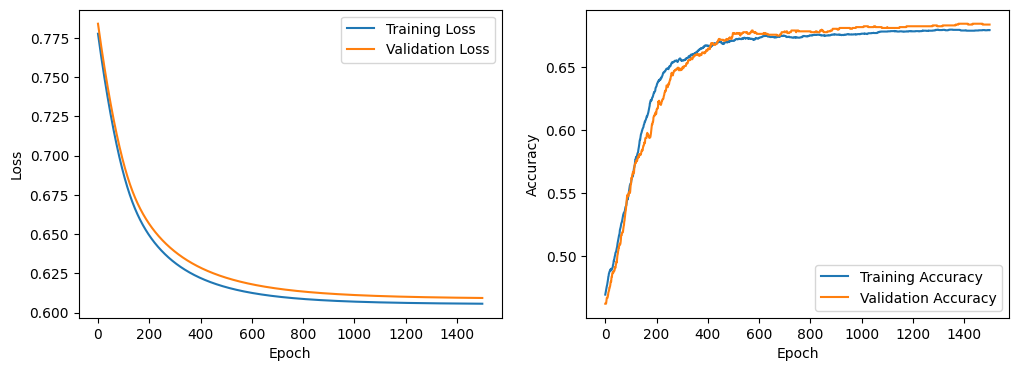

In [41]:

# Define logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

# Initialize the model, loss function, and optimizer
input_size = X_train_tensor.shape[1]
model = LogisticRegression(input_size)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay = 1e-4)

# Training loop
num_epochs = 1500
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Forward pass
    outputs_tensor = model(X_train_tensor)
    loss_tensor = criterion(outputs_tensor, y_train_tensor.view(-1, 1))

    # Calculate accuracy
    predictions_tensor = (outputs_tensor >= 0.5).float()
    accuracy_tensor = torch.mean((predictions_tensor == y_train_tensor.view(-1, 1)).float())

    # Backward and optimize
    optimizer.zero_grad()
    loss_tensor.backward()
    optimizer.step()

    # Validation loss and accuracy
    with torch.no_grad():
        val_outputs_tensor = model(X_val_tensor)
        val_loss_tensor = criterion(val_outputs_tensor, y_val_tensor.view(-1, 1))
        val_predictions_tensor = (val_outputs_tensor >= 0.5).float()
        val_accuracy_tensor = torch.mean((val_predictions_tensor == y_val_tensor.view(-1, 1)).float())

    # Save losses and accuracies for plotting
    train_losses.append(loss_tensor.item())
    val_losses.append(val_loss_tensor.item())
    train_accuracies.append(accuracy_tensor.item())
    val_accuracies.append(val_accuracy_tensor.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss_tensor.item():.4f}, Training Accuracy: {accuracy_tensor.item():.4f}, Validation Loss: {val_loss_tensor.item():.4f}, Validation Accuracy: {val_accuracy_tensor.item():.4f}')

# Plotting the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create a Logistic Regression model
logreg_model = LogisticRegression()

# Train the Logistic Regression model
logreg_model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred_logreg = logreg_model.predict(X_train)
accuracy_train_logreg = accuracy_score(y_train, y_train_pred_logreg)
print("Logistic Regression Training Accuracy:", accuracy_train_logreg)

# Make predictions on the validation set
y_val_pred_logreg = logreg_model.predict(X_val)
accuracy_val_logreg = accuracy_score(y_val, y_val_pred_logreg)
print("Logistic Regression Validation Accuracy:", accuracy_val_logreg)

Logistic Regression Training Accuracy: 0.55404953145917
Logistic Regression Validation Accuracy: 0.5394912985274432


Epoch [10/1500], Training Loss: 0.7257, Training Accuracy: 0.5000, Validation Loss: 0.7188, Validation Accuracy: 0.4967
Epoch [20/1500], Training Loss: 0.7189, Training Accuracy: 0.5077, Validation Loss: 0.7126, Validation Accuracy: 0.5120
Epoch [30/1500], Training Loss: 0.7125, Training Accuracy: 0.5154, Validation Loss: 0.7068, Validation Accuracy: 0.5241
Epoch [40/1500], Training Loss: 0.7067, Training Accuracy: 0.5233, Validation Loss: 0.7014, Validation Accuracy: 0.5315
Epoch [50/1500], Training Loss: 0.7012, Training Accuracy: 0.5301, Validation Loss: 0.6964, Validation Accuracy: 0.5462
Epoch [60/1500], Training Loss: 0.6960, Training Accuracy: 0.5405, Validation Loss: 0.6917, Validation Accuracy: 0.5556
Epoch [70/1500], Training Loss: 0.6912, Training Accuracy: 0.5487, Validation Loss: 0.6873, Validation Accuracy: 0.5596
Epoch [80/1500], Training Loss: 0.6867, Training Accuracy: 0.5572, Validation Loss: 0.6832, Validation Accuracy: 0.5622
Epoch [90/1500], Training Loss: 0.6824, 

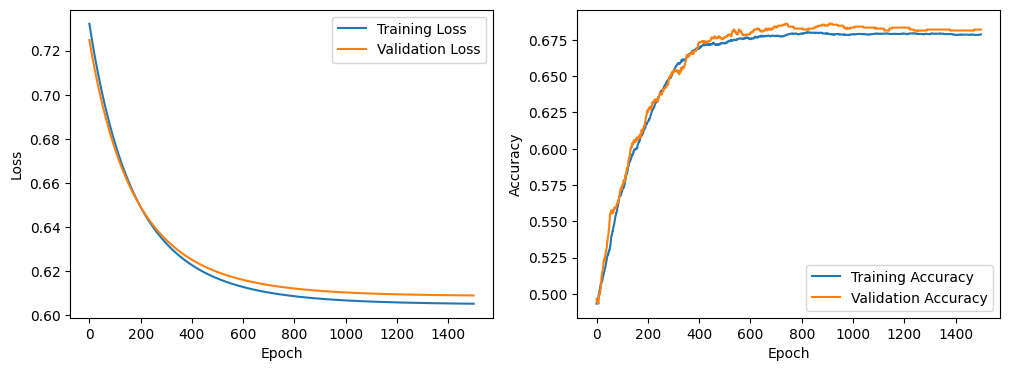

In [40]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Define logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

# Initialize the model, loss function, and optimizer
input_size = X_train_tensor.shape[1]
model = LogisticRegression(input_size)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay = 1e-4)

# Training loop
num_epochs = 1500
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Forward pass
    outputs_tensor = model(X_train_tensor)
    loss_tensor = criterion(outputs_tensor, y_train_tensor.view(-1, 1))

    # Calculate accuracy
    predictions_tensor = (outputs_tensor >= 0.5).float()
    accuracy_tensor = torch.mean((predictions_tensor == y_train_tensor.view(-1, 1)).float())

    # Backward and optimize
    optimizer.zero_grad()
    loss_tensor.backward()
    optimizer.step()

    # Validation loss and accuracy
    with torch.no_grad():
        val_outputs_tensor = model(X_val_tensor)
        val_loss_tensor = criterion(val_outputs_tensor, y_val_tensor.view(-1, 1))
        val_predictions_tensor = (val_outputs_tensor >= 0.5).float()
        val_accuracy_tensor = torch.mean((val_predictions_tensor == y_val_tensor.view(-1, 1)).float())

    # Save losses and accuracies for plotting
    train_losses.append(loss_tensor.item())
    val_losses.append(val_loss_tensor.item())
    train_accuracies.append(accuracy_tensor.item())
    val_accuracies.append(val_accuracy_tensor.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss_tensor.item():.4f}, Training Accuracy: {accuracy_tensor.item():.4f}, Validation Loss: {val_loss_tensor.item():.4f}, Validation Accuracy: {val_accuracy_tensor.item():.4f}')

# Plotting the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 2.2 K-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Create a KNN model with k=3 (you can adjust the value of k)
knn_model = KNeighborsClassifier(n_neighbors=3)

# Train the KNN model
knn_model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred_knn = knn_model.predict(X_train)
accuracy_train_knn = accuracy_score(y_train, y_train_pred_knn)
print("KNN Training Accuracy:", accuracy_train_knn)

# Make predictions on the validation set
y_val_pred_knn = knn_model.predict(X_val)
accuracy_val_knn = accuracy_score(y_val, y_val_pred_knn)
print("KNN Validation Accuracy:", accuracy_val_knn)

KNN Training Accuracy: 0.7943440428380187
KNN Validation Accuracy: 0.5937081659973227


## 2.3 Random Forests

Random Forest Training Accuracy: 0.7024765729585006
Random Forest Validation Accuracy: 0.678045515394913


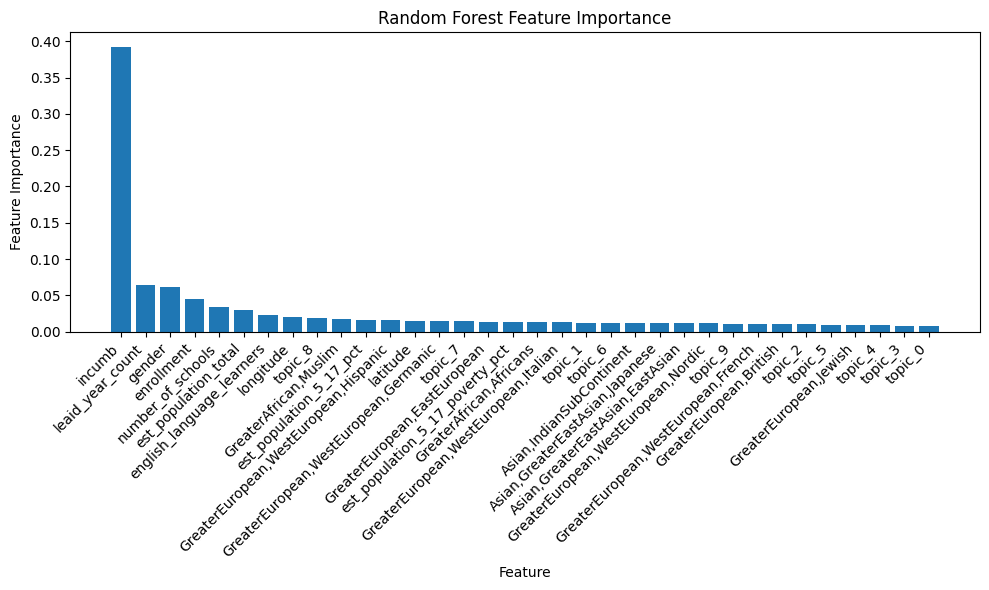

In [ ]:
# Train Random Forest
random_forest_model = RandomForestClassifier(random_state=41, max_depth=5)
random_forest_model.fit(X_train, y_train)

y_train_pred_rf = random_forest_model.predict(X_train)
accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
print("Random Forest Training Accuracy:", accuracy_rf)

y_val_pred_rf = random_forest_model.predict(X_val)
accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
print("Random Forest Validation Accuracy:", accuracy_rf)

feature_importances = random_forest_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=45, ha="right")
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

## 2.4 Gradient Boosting Classifier

GBM Validation Accuracy: 0.6894243641231593


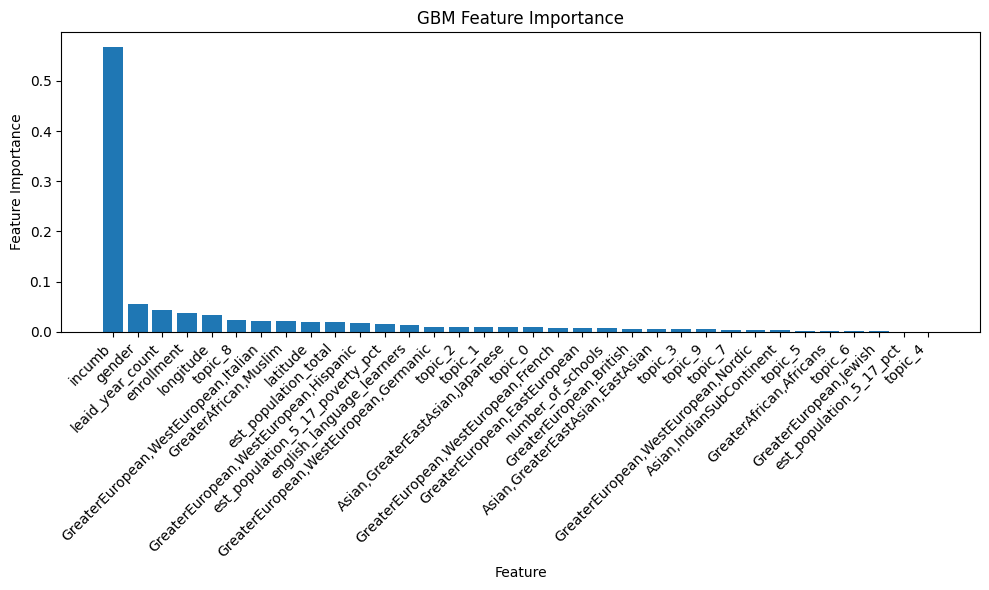

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import make_scorer, accuracy_score
import numpy as np

# Assuming you have your data (X_train, y_train) and feature_names defined

# Create a Gradient Boosting Classifier
gbm_model = GradientBoostingClassifier(random_state=42, n_estimators=15, learning_rate=0.3, max_depth=3)

# Perform 5-fold cross-validation
#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring metric (accuracy in this case)
#scorer = make_scorer(accuracy_score)

# Perform cross-validation and print the results
##cross_val_results = cross_val_score(gbm_model, X_train, y_train, cv=cv, scoring=scorer)
#print("Cross-Validation Results (Accuracy):", cross_val_results)
#print("Mean Accuracy:", np.mean(cross_val_results))

# Train the GBM model on the entire training set
gbm_model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred_gbm = gbm_model.predict(X_val)
accuracy_val_gbm = accuracy_score(y_val, y_val_pred_gbm)
print("GBM Validation Accuracy:", accuracy_val_gbm)

# Feature importance plotting (similar to your original code)
feature_importances = gbm_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=45, ha="right")
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("GBM Feature Importance")
plt.tight_layout()
plt.show()

## 2.5 XGBoost

XGBoost Training Accuracy: 0.6890896921017403
XGBoost Validation Accuracy: 0.6914323962516734


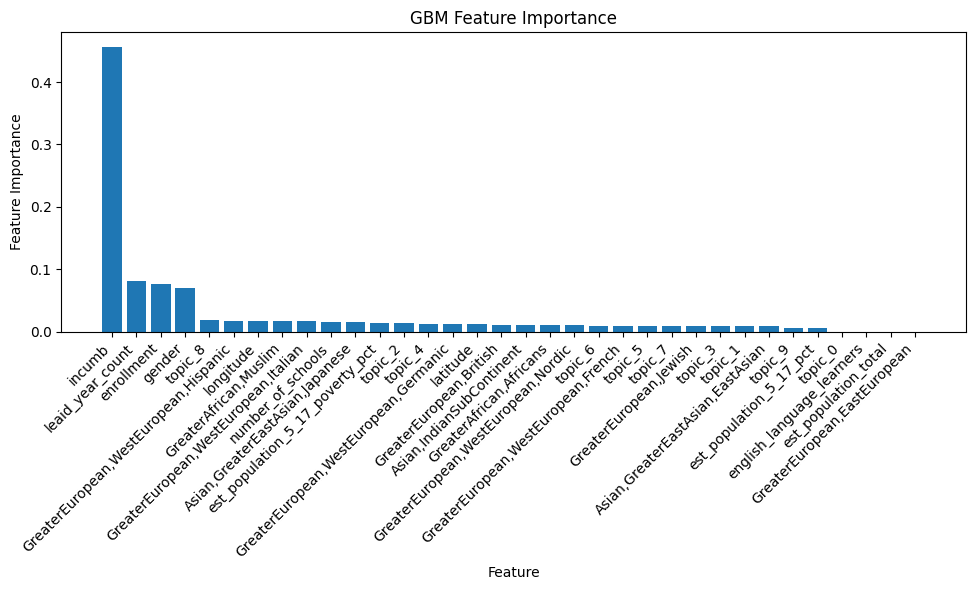

In [ ]:
xgboost_model = XGBClassifier(random_state=42, max_depth=1)
xgboost_model.fit(X_train, y_train)

y_train_pred_xgb = xgboost_model.predict(X_train)
accuracy_xgb = accuracy_score(y_train, y_train_pred_xgb)
print("XGBoost Training Accuracy:", accuracy_xgb)

y_val_pred_xgb = xgboost_model.predict(X_val)
accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)
print("XGBoost Validation Accuracy:", accuracy_xgb)


feature_importances = xgboost_model.feature_importances_

# Get the names of t he features

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=45, ha="right")
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("GBM Feature Importance")
plt.tight_layout()
plt.show()

## 2.6 SVMs

In [ ]:
# Train Support Vector Machine (SVM)
# svm_model = SVC(kernel='rbf', gamma=0.02,random_state=42)
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)

y_train_pred_svm = svm_model.predict(X_train)
accuracy_svm = accuracy_score(y_train, y_train_pred_svm)
print("SVM Training Accuracy:", accuracy_svm)

y_val_pred_svm = svm_model.predict(X_val)
accuracy_svm = accuracy_score(y_val, y_val_pred_svm)
print("SVM Validation Accuracy:", accuracy_svm)

SVM Training Accuracy: 0.7342704149933066
SVM Validation Accuracy: 0.677376171352075


In [ ]:
!pip install torch

## 2.7 Fully Connected Neural Network

LOG: Fold [1/5], Epoch [10/150], Training Loss: 0.6624, Training Accuracy: 0.5890, Validation Loss: 0.6489, Validation Accuracy: 0.6205
LOG: Fold [1/5], Epoch [20/150], Training Loss: 0.6306, Training Accuracy: 0.6670, Validation Loss: 0.6289, Validation Accuracy: 0.6727
LOG: Fold [1/5], Epoch [30/150], Training Loss: 0.6172, Training Accuracy: 0.6745, Validation Loss: 0.6190, Validation Accuracy: 0.6821
LOG: Fold [1/5], Epoch [40/150], Training Loss: 0.6206, Training Accuracy: 0.6764, Validation Loss: 0.6173, Validation Accuracy: 0.6867
LOG: Fold [1/5], Epoch [50/150], Training Loss: 0.6160, Training Accuracy: 0.6750, Validation Loss: 0.6172, Validation Accuracy: 0.6801
LOG: Fold [1/5], Epoch [60/150], Training Loss: 0.6115, Training Accuracy: 0.6826, Validation Loss: 0.6186, Validation Accuracy: 0.6807
LOG: Fold [1/5], Epoch [70/150], Training Loss: 0.6134, Training Accuracy: 0.6816, Validation Loss: 0.6061, Validation Accuracy: 0.6881
LOG: Fold [1/5], Epoch [80/150], Training Loss: 

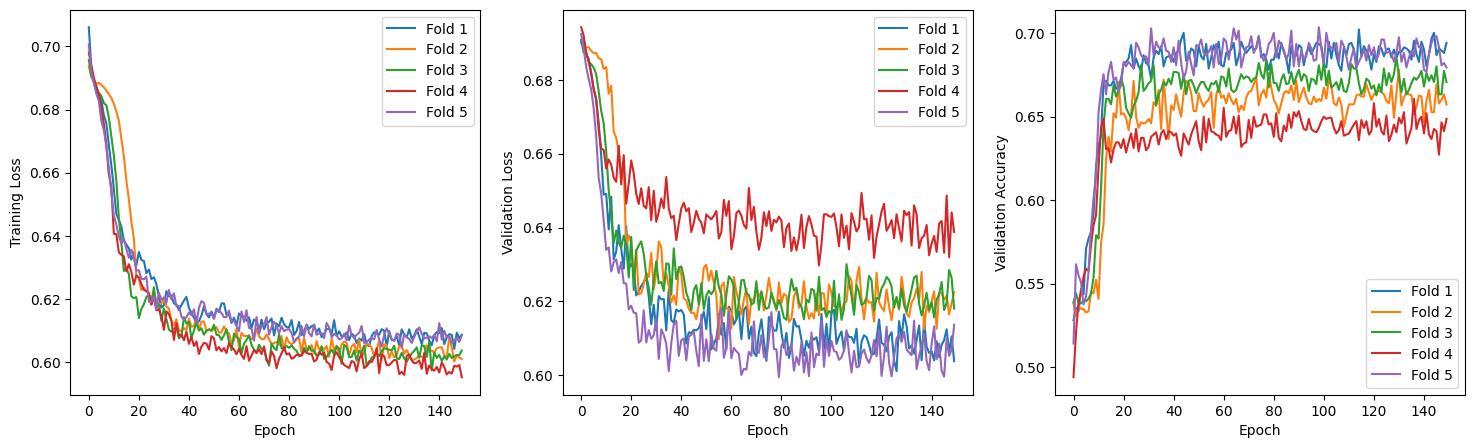

In [ ]:
# Define a simple neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Adjust dropout rate as needed
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

class LargerNeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(LargerNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.6)

        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.6)

        self.fc3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.6)

        self.fc4 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        x = self.sigmoid(x)
        return x


from sklearn.model_selection import StratifiedKFold

# Combine train and validation sets for cross-validation split
X_combined = torch.cat([X_train_tensor, X_val_tensor], dim=0)
y_combined = torch.cat([y_train_tensor, y_val_tensor], dim=0)

# Set the number of folds for cross-validation
num_folds = 5
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store results from each fold
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []
all_test_accuracies = []

best_val_accuracies = []
best_train_accuracies = []

for fold, (train_index, val_index) in enumerate(kf.split(X_combined, y_combined)):
    # Split data into training and validation sets
    X_train_fold, X_val_fold = X_combined[train_index], X_combined[val_index]
    y_train_fold, y_val_fold = y_combined[train_index], y_combined[val_index]

    # Initialize the model, loss function, and optimizer
    input_size = X_train_fold.shape[1]
    model = LargerNeuralNetwork(input_size)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=10e-3)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

    # Training loop
    num_epochs = 150
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    max_val_accuracy = 0
    max_train_accuracy = 0

    for epoch in range(num_epochs):

        # Forward pass
        outputs_tensor = model(X_train_fold)
        loss_tensor = criterion(outputs_tensor, y_train_fold.view(-1, 1))

        # Calculate accuracy
        predictions_tensor = (outputs_tensor >= 0.5).float()
        accuracy_tensor = torch.mean((predictions_tensor == y_train_fold.view(-1, 1)).float())

        if max_train_accuracy < accuracy_tensor.item():
            max_train_accuracy = accuracy_tensor.item()


        # Backward and optimize
        optimizer.zero_grad()
        loss_tensor.backward()
        optimizer.step()
        scheduler.step()
        # Validation loss and accuracy
        with torch.no_grad():
            val_outputs_tensor = model(X_val_fold)
            val_loss_tensor = criterion(val_outputs_tensor, y_val_fold.view(-1, 1))
            val_predictions_tensor = (val_outputs_tensor >= 0.5).float()
            val_accuracy_tensor = torch.mean((val_predictions_tensor == y_val_fold.view(-1, 1)).float())
            if max_val_accuracy < val_accuracy_tensor:
                max_val_accuracy = val_accuracy_tensor.item()

                # Save the model weights
                torch.save(model.state_dict(), f'best_model_weights_fold_{fold + 1}.pth')
                #print(f'New Best Validation Accuracy of {max_val_accuracy:.4f} was found for fold {fold + 1}!')

        # Save losses and accuracies for plotting
        train_losses.append(loss_tensor.item())
        val_losses.append(val_loss_tensor.item())
        train_accuracies.append(accuracy_tensor.item())
        val_accuracies.append(val_accuracy_tensor.item())

        if (epoch + 1) % 10 == 0:
            print(f'LOG: Fold [{fold + 1}/{num_folds}], Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss_tensor.item():.4f}, Training Accuracy: {accuracy_tensor.item():.4f}, Validation Loss: {val_loss_tensor.item():.4f}, Validation Accuracy: {val_accuracy_tensor.item():.4f}')

    # Store results from each fold
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)

    # Evaluation on the validation set using the best model
    best_model_fold = LargerNeuralNetwork(input_size)
    model_filename = f'best_model_weights_fold_{fold + 1}.pth'

    # Load the model weights
    best_model_fold.load_state_dict(torch.load(model_filename))

    print(f"Fold {fold + 1} Training Accuracy:", max_train_accuracy)
    print(f"Fold {fold + 1} Validation Accuracy:", max_val_accuracy)

    # log the best validation accuracy
    best_val_accuracies.append(max_val_accuracy)
    best_train_accuracies.append(max_train_accuracy)

    '''
    # Evaluation on the test set using the best model
    with torch.no_grad():
        test_outputs_tensor_fold = best_model_fold(X_test_tensor)
        test_predictions_tensor_fold = (test_outputs_tensor_fold >= 0.5).float()
        test_accuracy_tensor_fold = torch.mean((test_predictions_tensor_fold == y_test_tensor.view(-1, 1)).float())
        print(f"Fold {fold + 1} Test Accuracy:", test_accuracy_tensor_fold.item())

    # Store results from each fold
    all_test_accuracies.append(test_accuracy_tensor_fold.item())
    '''
# After all folds, you can compute
'''
avg_test_accuracy = sum(all_test_accuracies) / len(all_test_accuracies)
print("Average Test Accuracy:", avg_test_accuracy)
'''

# Plotting the training and validation loss
plt.figure(figsize=(18, 5))

# Plotting the training loss
plt.subplot(1, 3, 1)
for fold, train_losses_fold in enumerate(all_train_losses):
    plt.plot(train_losses_fold, label=f'Fold {fold + 1}')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()

# Plotting the validation loss
plt.subplot(1, 3, 2)
for fold, val_losses_fold in enumerate(all_val_losses):
    plt.plot(val_losses_fold, label=f'Fold {fold + 1}')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 3, 3)
for fold, val_accuracies_fold in enumerate(all_val_accuracies):
    plt.plot(val_accuracies_fold, label=f'Fold {fold + 1}')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()

plt.show()



In [ ]:
print("Average Training Accuracy accros all folds: ", np.mean(best_train_accuracies))
print("Average Validation Accuracy accros all folds: ", np.mean(best_val_accuracies))

Average Training Accuracy accros all folds:  0.6980589032173157
Average Validation Accuracy accros all folds:  0.6859437704086304


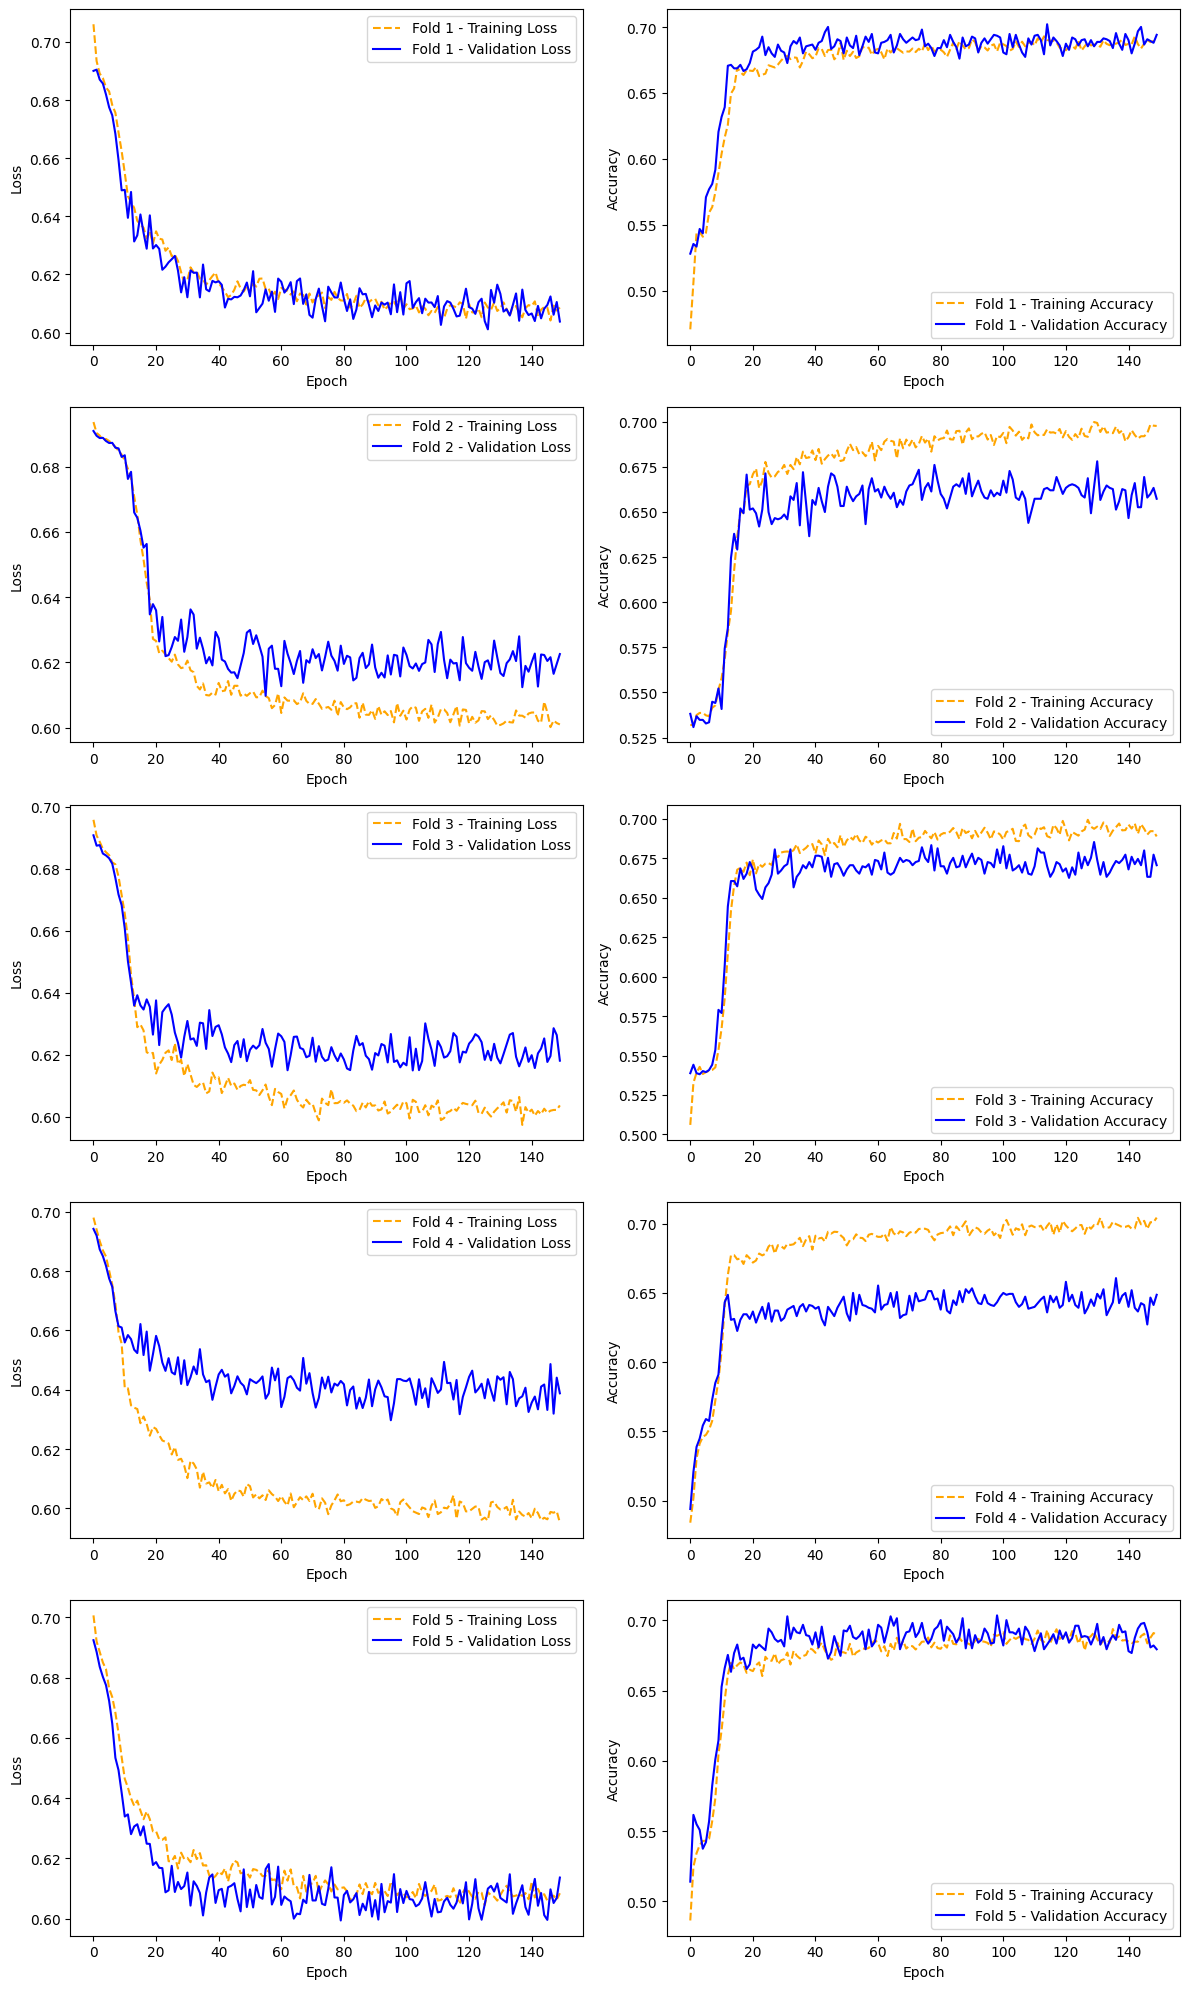

In [ ]:
# Assuming all_train_losses, all_val_losses, all_train_accuracies, and all_val_accuracies are lists of lists where each inner list corresponds to a fold.

# Plotting the training and validation loss and accuracy for each fold
num_folds = len(all_train_losses)

plt.figure(figsize=(12, 4 * num_folds))

for fold in range(num_folds):
    # Plotting training loss
    plt.subplot(num_folds, 2, fold * 2 + 1)
    plt.plot(all_train_losses[fold], label=f'Fold {fold + 1} - Training Loss', linestyle='--', color='orange')
    plt.plot(all_val_losses[fold], label=f'Fold {fold + 1} - Validation Loss', linestyle='-', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting training accuracy
    plt.subplot(num_folds, 2, fold * 2 + 2)
    plt.plot(all_train_accuracies[fold], label=f'Fold {fold + 1} - Training Accuracy', linestyle='--', color='orange')
    plt.plot(all_val_accuracies[fold], label=f'Fold {fold + 1} - Validation Accuracy', linestyle='-', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

## 2.8 TabNet

In [ ]:
#!pip install pytorch-tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from sklearn.metrics import accuracy_score
import torch

TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax' # "sparsemax"
)

unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_val],
    pretraining_ratio=0.8,
)

clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=7e-2),
    scheduler_params={"step_size":10, # how to use learning rate scheduler
                      "gamma":0.6},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax' # This will be overwritten if using pretrain model
)

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    from_unsupervised=unsupervised_model
)


# Make predictions on the training set
y_train_pred_tabnet = clf.predict(X_train)
accuracy_train_tabnet = accuracy_score(y_train, y_train_pred_tabnet)
print("TabNet Training Accuracy:", accuracy_train_tabnet)

# Make predictions on the validation set
y_val_pred_tabnet = clf.predict(X_val)
accuracy_val_tabnet = accuracy_score(y_val, y_val_pred_tabnet)
print("TabNet Validation Accuracy:", accuracy_val_tabnet)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.0684  | val_0_unsup_loss_numpy: 1.06850004196167|  0:00:00s
epoch 1  | loss: 1.72666 | val_0_unsup_loss_numpy: 1.0618000030517578|  0:00:01s
epoch 2  | loss: 1.29235 | val_0_unsup_loss_numpy: 1.0234099626541138|  0:00:01s
epoch 3  | loss: 1.09687 | val_0_unsup_loss_numpy: 1.031559944152832|  0:00:02s
epoch 4  | loss: 1.01416 | val_0_unsup_loss_numpy: 1.004889965057373|  0:00:03s
epoch 5  | loss: 1.02578 | val_0_unsup_loss_numpy: 1.0024199485778809|  0:00:03s
epoch 6  | loss: 1.01567 | val_0_unsup_loss_numpy: 1.0022000074386597|  0:00:04s
epoch 7  | loss: 1.01895 | val_0_unsup_loss_numpy: 1.0006300210952759|  0:00:04s
epoch 8  | loss: 1.00579 | val_0_unsup_loss_numpy: 0.9986900091171265|  0:00:05s
epoch 9  | loss: 0.99774 | val_0_unsup_loss_numpy: 0.9974499940872192|  0:00:05s
epoch 10 | loss: 0.99915 | val_0_unsup_loss_numpy: 0.9967300295829773|  0:00:06s
epoch 11 | loss: 0.99626 | val_0_unsup_loss_numpy: 0.9966599941253662|  0:00:06s
epoch 12 | loss: 0.99436 | val_0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:118: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.88009 | train_accuracy: 0.54987 | valid_accuracy: 0.52544 |  0:00:00s
epoch 1  | loss: 0.68937 | train_accuracy: 0.55438 | valid_accuracy: 0.53548 |  0:00:01s
epoch 2  | loss: 0.68419 | train_accuracy: 0.55238 | valid_accuracy: 0.55756 |  0:00:01s
epoch 3  | loss: 0.68072 | train_accuracy: 0.57497 | valid_accuracy: 0.56292 |  0:00:02s
epoch 4  | loss: 0.65773 | train_accuracy: 0.6071  | valid_accuracy: 0.61312 |  0:00:02s
epoch 5  | loss: 0.64735 | train_accuracy: 0.61111 | valid_accuracy: 0.60442 |  0:00:03s
epoch 6  | loss: 0.6351  | train_accuracy: 0.63588 | valid_accuracy: 0.62249 |  0:00:04s
epoch 7  | loss: 0.63018 | train_accuracy: 0.64742 | valid_accuracy: 0.62651 |  0:00:04s
epoch 8  | loss: 0.62644 | train_accuracy: 0.64926 | valid_accuracy: 0.63722 |  0:00:05s
epoch 9  | loss: 0.62126 | train_accuracy: 0.65546 | valid_accuracy: 0.64056 |  0:00:06s
epoch 10 | loss: 0.61686 | train_accuracy: 0.65746 | valid_accuracy: 0.64592 |  0:00:07s
epoch 11 | loss: 0.61

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet Training Accuracy: 0.6820615796519411
TabNet Validation Accuracy: 0.6613119143239625
